# Computer Vision models tips for production

In this notebook, I provide useful **tips** on how not to mess up the Computer Vision model in production. I cover **4 real cases** that I've met while working as an ML engineer.

Each is related to image processing before passing it to the algorithm (mainly neural networks):
* Orientation stored in EXIF
* Non-standrad color profile
* Differences in image libraries
* Resizing algorithms

There is a corresponding **blog post** [here](link).

In [1]:
import io
import os
import glob
import time
from typing import List, Callable, Any

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import PIL
import PIL.ImageCms
import PIL.ImageOps
import HeifImagePlugin

import cv2

import skimage.io
import skimage.transform

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=14)

# Orientation stored in EXIF 

Often mobile device stores the image in some pre-determined fixed orientation no matter what the real camera position was when the photo was taken. The rotation angle necessary to restore the initial orientation is stored as the meta-information in EXIF.

The examples below are real images shot on my iPhone 12.

## JPEG

Read image with PIL

In [2]:
input_image = "../data/cup.jpg"

In [3]:
image = PIL.Image.open(input_image)
np_image_initial = np.array(image)

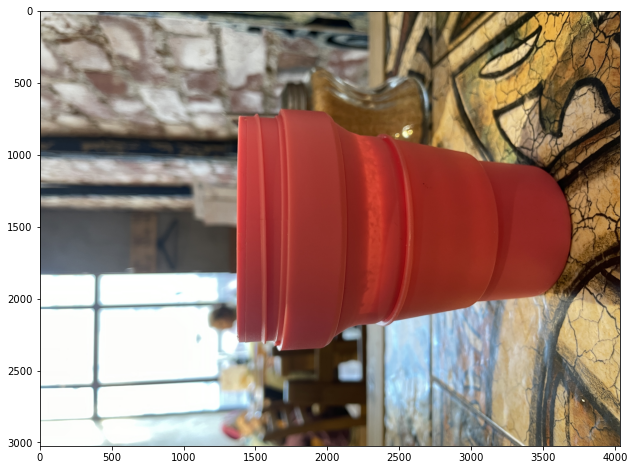

In [4]:
plt.figure(figsize=(20, 8))
plt.imshow(np_image_initial);

Raw pixels are stored horizontally. Therefore one needs to read EXIF meta-information and rotate/mirror an image to restore the initial orientation.

Look [here](https://exiftool.org/TagNames/EXIF.html) for more information on EXIF tags.

In [5]:
# get image EXIF
image_exif = image.getexif()
# retrieve orientation byte
orientation = image_exif.get(0x0112)
print(orientation)

6


In [6]:
# get the corresponding transformation
method = {
    2: PIL.Image.FLIP_LEFT_RIGHT,
    3: PIL.Image.ROTATE_180,
    4: PIL.Image.FLIP_TOP_BOTTOM,
    5: PIL.Image.TRANSPOSE,
    6: PIL.Image.ROTATE_270,
    7: PIL.Image.TRANSVERSE,
    8: PIL.Image.ROTATE_90,
}.get(orientation)
if method is not None:
    # replace original orientation
    image_exif[0x0112] = 1
    # apply transformation
    image = image.transpose(method)

In [7]:
np_image_correct = np.array(image)

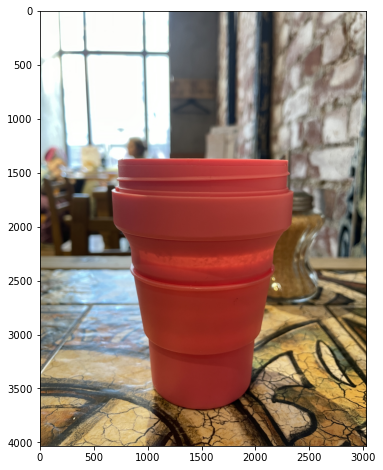

In [8]:
plt.figure(figsize=(20, 8))
plt.imshow(np_image_correct);

Now the image looks ok.

## HEIC

Let's now try another modern image format which is HEIC. iPhone shots HDR photos in this format by default.

Read image with PIL.

In [9]:
input_image = "../data/person.heic"

In [10]:
image = PIL.Image.open(input_image)
np_image_initial = np.array(image)

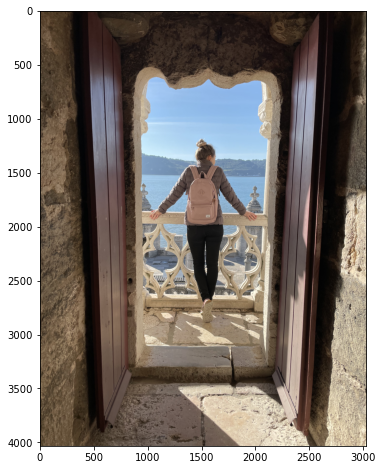

In [11]:
plt.figure(figsize=(20, 8))
plt.imshow(np_image_initial);

The raw pixels orientation is correct!

In [12]:
# get image EXIF
image_exif = image.getexif()
# get image format
image_format = image.format
# retrieve orientation byte
orientation = image_exif.get(0x0112)
print(orientation)
print(image_format)

6
HEIF


But EXIF still says that we should rotate it. But one clearly should not do it.

Let's add this condition to the code.

In [13]:
# get the corresponding transformation
method = {
    2: PIL.Image.FLIP_LEFT_RIGHT,
    3: PIL.Image.ROTATE_180,
    4: PIL.Image.FLIP_TOP_BOTTOM,
    5: PIL.Image.TRANSPOSE,
    6: PIL.Image.ROTATE_270,
    7: PIL.Image.TRANSVERSE,
    8: PIL.Image.ROTATE_90,
}.get(orientation)
if method is not None:
    # replace original orientation
    image_exif[0x0112] = 1
    if image_format != "HEIF":
        # apply transformation if not HEIF
        image = image.transpmemoryviewe(method)

In [14]:
np_image_correct = np.array(image)

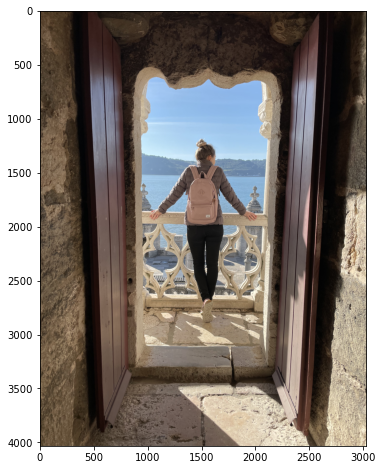

In [15]:
plt.figure(figsize=(20, 8))
plt.imshow(np_image_correct);

Now it works for both JPEG and HEIC images shot on iPhone.

For other device one might need more exploration and this code might grow even more.

# Non-standrad color profile

Meta-information hides one more challenge. Pictures might be taken and stored in different color spaces and color profiles. RGB color space has lots of different profiles: sRGB, Adobe RGB, Display P3, etc. Each profile defines its own way of mapping raw RGB values into the real colors that the human eye percepts.

It leads to the fact that the same raw RGB values might imply different colors in different pictures. To tackle this problem one needs to carefully convert color profiles of all images into one chosen standard. Usually, it is an sRGB profile because due to historical reasons it is a default color profile for all the web.

Let's read image with PIL and see how it looks like with and without color profile conversion.

In [16]:
input_image = "../data/city.heic"

In [17]:
image_initial = PIL.Image.open(input_image)

Convert color profile to sRGB

In [18]:
# open default ICC profile which is sRGB
working_icc_profile = PIL.ImageCms.getOpenProfile(
    "../data/SRGB.icc"
)
# read ICC profile from the image
image_icc_profile = PIL.ImageCms.getOpenProfile(
    io.BytesIO(image_initial.info["icc_profile"])
)

# convert an image to default ICC profile
image_converted = PIL.ImageCms.profileToProfile(
    im=image_initial,
    inputProfile=image_icc_profile,
    outputProfile=working_icc_profile,
    renderingIntent=PIL.ImageCms.INTENT_PERCEPTUAL,
    outputMode="RGB"
)

In [19]:
image_initial_np = np.array(image_initial)
image_converted_np = np.array(image_converted)

Draw the difference. Right column shows image which was read taking in account color profile. Left column shows the raw pixel values.

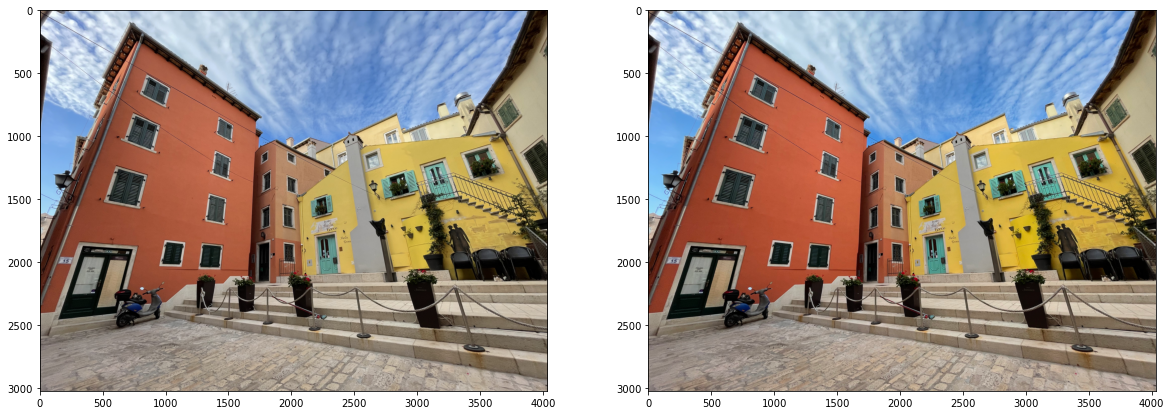

In [20]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(image_initial_np)
plt.subplot(122)
plt.imshow(image_converted_np);

Draw the difference. Right column shows image which was read taking in account color profile. Left column shows the raw pixel values.

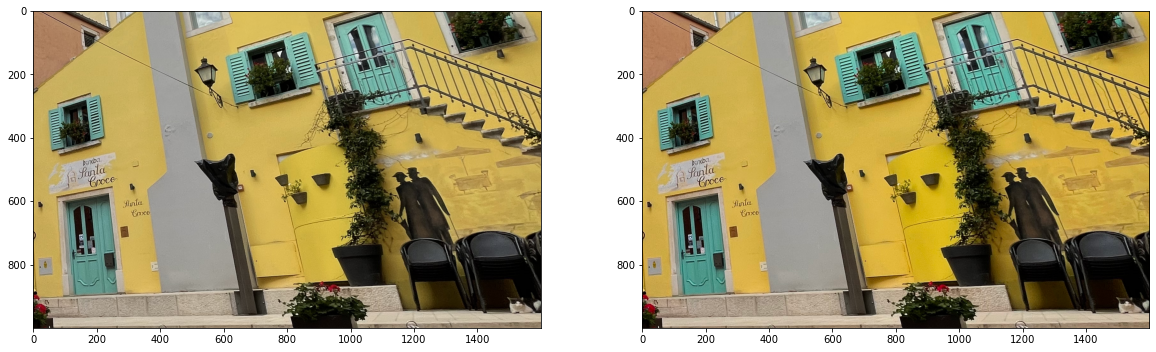

In [21]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(image_initial_np[1200:2200, 2100:3700])
plt.subplot(122)
plt.imshow(image_converted_np[1200:2200, 2100:3700]);

Draw the difference. Right column shows image which was read taking in account color profile. Left column shows the raw pixel values.

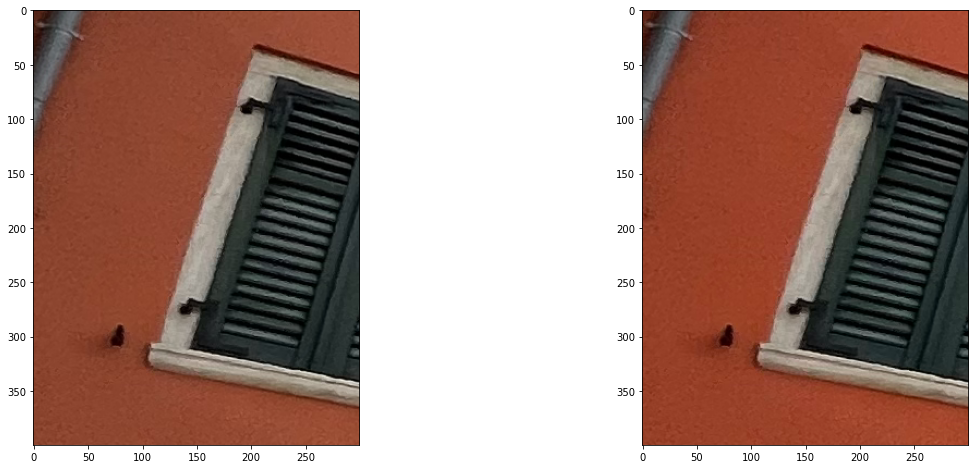

In [22]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(image_initial_np[1200:1600, 400:700])
plt.subplot(122)
plt.imshow(image_converted_np[1200:1600, 400:700]);

One can see that the image read with color profile conversion is more vibrant and is closer to the original. Depending on the picture and color profile, this difference might be bigger or smaller. Some images might even look like sepia without profile conversion.

# Differences in image libraries

Now let's also take a look at how different image libraries differ in speed and results they produce. Here I would compare: 
* [OpenCV](https://opencv.org)
* [PIL](https://github.com/python-pillow/Pillow)
* [Scikit-image](https://scikit-image.org)

In [2]:
def measure_time(
    f: Callable[[], Any], 
    num: int = 20
) -> List[float]:
    """
    Runs `f` for `num` times and 
    return all recorded execution times.
    """
    times = []
    for _ in range(num):
        start_time = time.time()
        f()
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [3]:
input_image = "../data/landscape.jpg"

## Reading

First of all, I would look at reading functions. To do that I generate 37 copies of the same image but in different sizes.

In [4]:
def generate_different_sizes(
    input_image: str, 
    output_folder: str
) -> None:
    """
    Generate `input_image` copies of different sizes and 
    put them into `output_folder`.
    """
    image = PIL.Image.open(input_image)
    os.makedirs(output_folder, exist_ok=True)
    for largest_side in tqdm(range(100, max(image.size), 200)):
        _temp = image.copy()
        _temp.thumbnail((largest_side, largest_side))
        filename = os.path.basename(input_image)
        filename_split = os.path.splitext(filename)
        filename = filename_split[0] + f"_{largest_side:04d}" + filename_split[1]
        _temp.save(os.path.join(output_folder, filename))

In [26]:
generate_different_sizes(input_image, "../data/landscape_all_sizes")

  0%|          | 0/37 [00:00<?, ?it/s]

Get the list of all generated images

In [5]:
filelist = sorted(glob.glob("../data/landscape_all_sizes/*.jpg"))

In [6]:
def measure_read_times(
    f: Callable[[str], Any], 
    filelist: List[str], 
    num: int = 20
) -> List[List[float]]:
    """
    Goes over `filelist` and measure the time of 
    applying `f` to each entry `num` times.
    """
    times = []
    for file in tqdm(filelist):
        times.append(measure_time(lambda: f(file), num=num))
    return times

Define functions that read image for each of the libraries

In [7]:
def read_cv2(file: str) -> np.ndarray:
    image_cv2 = cv2.cvtColor(
        cv2.imread(
            file, 
            cv2.IMREAD_UNCHANGED
        ), 
        cv2.COLOR_BGR2RGB
    )
    return image_cv2

def read_pil(file: str) -> PIL.Image.Image:
    image_pil = PIL.Image.open(file)
    _ = np.array(image_pil)
    return image_pil

def read_skimage(file: str) -> np.ndarray:
    image_skimage = skimage.io.imread(file)
    return image_skimage

Run the experiment.

Here I read all the images of the different sizes 10 times. And do it for each of the libraries.

In [15]:
num_repeats = 10
time.sleep(5)
times_read_cv2 = measure_read_times(read_cv2, filelist, num_repeats)
time.sleep(5)
times_read_pil = measure_read_times(read_pil, filelist, num_repeats)
time.sleep(5)
times_read_skimage = measure_read_times(read_skimage, filelist, num_repeats)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Gather results

In [20]:
sizes = [int(os.path.basename(f).split("_")[-1][:4]) for f in filelist]

df_cv2 = pd.DataFrame()
df_cv2["size, px"] = np.repeat(sizes, num_repeats)
df_cv2["time, s"] = np.array(times_read_cv2).flatten()
df_cv2["libary"] = "cv2"

df_pil = pd.DataFrame()
df_pil["size, px"] = np.repeat(sizes, num_repeats)
df_pil["time, s"] = np.array(times_read_pil).flatten()
df_pil["libary"] = "pil"

df_skimage = pd.DataFrame()
df_skimage["size, px"] = np.repeat(sizes, num_repeats)
df_skimage["time, s"] = np.array(times_read_skimage).flatten()
df_skimage["libary"] = "skimage"

df_overall = pd.concat([df_cv2, df_pil, df_skimage]).reset_index(drop=True)

Draw results

(0.0, 0.5369327068328857)

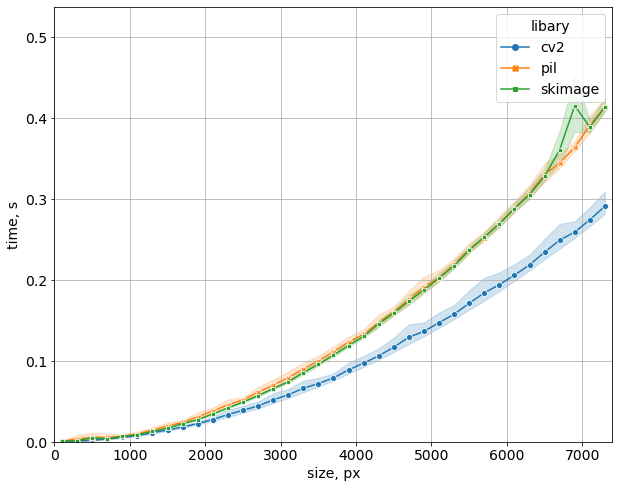

In [22]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=df_overall,
    x="size, px", y="time, s", hue="libary", style="libary",
    markers=True, dashes=False,
)
plt.grid(True)
plt.xlim([0, sizes[-1] + 100])
plt.ylim([0, max(df_overall["time, s"])]);

The graph shows how different libraries reading speed depends on the image size.

For small images, there is almost no difference. But for the big ones, the OpenCV is approximately 1.5x times faster than PIL and Scikit-image. This difference might vary from 1.4x to 2.0x depending on the image content and format (JPEG, PNG, etc.). But in general, OpenCV is much faster.

Let's also read and image by different libraries and see whether they are the same.

In [12]:
image_cv2 = read_cv2(input_image)
image_pil = read_pil(input_image)
image_skimage = read_skimage(input_image)

In [13]:
(np.array(image_pil) == image_cv2).all()

True

In [14]:
(image_cv2 == image_skimage).all()

True

Yes, all the libraries read image in the same way.

## Resizing

One more extremely common operation is resizing. One almost always resizes images before sending them into the neural net. And this is where OpenCV really shines.

Here I take one 7360x4100 image and resize it down to 1000x1000.

In [52]:
times_resize_cv2 = measure_time(
    f=lambda: cv2.resize(image_cv2, (1000, 1000), interpolation=cv2.INTER_LINEAR),
    num=20,
)

In [25]:
times_resize_pil = measure_time(
    f=lambda: image_pil.resize((1000, 1000), resample=PIL.Image.LINEAR),
    num=20,
)

In [54]:
times_resize_skimage = measure_time(
    f=lambda: skimage.transform.resize(image_skimage, (1000, 1000), order=1),
    num=20,
)

In [53]:
print(f"cv2:       {np.mean(times_resize_cv2):.3f}s")
print(f"pil:       {np.mean(times_resize_pil):.3f}s")
print(f"skimage:   {np.mean(times_resize_skimage):.3f}s")

cv2:       0.004s
pil:       0.135s
skimage:   4.531s


OpenCV does it 22x faster than PIL and 755x faster than Scikit-image!

Let's also take a look at whether the results of resizing are different.

In [35]:
image_cv2_resized = cv2.resize(
    image_cv2, 
    (1000, 1000), 
    interpolation=cv2.INTER_LINEAR
)

image_pil_resized = image_pil.resize(
    (1000, 1000), 
    resample=PIL.Image.LINEAR
)

In [49]:
print(
    "Original images are the same:                    ", 
    (image_cv2 == np.array(image_pil)).all()
)
print(
    "Resized images are the same:                     ", 
    (image_cv2_resized == np.array(image_pil_resized)).all()
)
mae = np.abs(image_cv2_resized.astype(int) - 
             np.array(image_pil_resized, dtype=int)).mean()
print(
    "Mean Absolute Difference between resized images: ",
    f"{mae:.2f}"
)

Original images are the same:                     True
Resized images are the same:                      False
Mean Absolute Difference between resized images:  5.37


Here one can notice that I do downsampling with linear interpolation for both OpenCV and PIL. The original images are the same. But the rezised results are different. And the difference is quite significant: 5 out of 255 on average for each pixel color.

# Resizing algorithms

Apart from speed differences across libraries, there are different resizing algorithms even inside one library. Which of them should one choose?

At least, it depends on whether one wants to decrease the image size (downsample) or increase it (upsample).

In [2]:
input_image = "../data/landscape.jpg"

## Downsampling

Read image with OpenCV

In [3]:
image = cv2.cvtColor(
    cv2.imread(
        input_image, 
        cv2.IMREAD_UNCHANGED
    ), 
    cv2.COLOR_BGR2RGB
)

There are [numerous algorithms](https://en.wikipedia.org/wiki/Image_scaling#Algorithms) to resize images. They differ in the resulting image quality and speed. I would look only at those 5, which are good and fast enough and are supported in mainstream libraries.

In [4]:
algos = {
    "AREA": cv2.INTER_AREA,
    "NEAREST": cv2.INTER_NEAREST,
    "LINEAR": cv2.INTER_LINEAR,
    "CUBIC": cv2.INTER_CUBIC,
    "LANCZOS": cv2.INTER_LANCZOS4,
}

Go over each algorithm and compare results

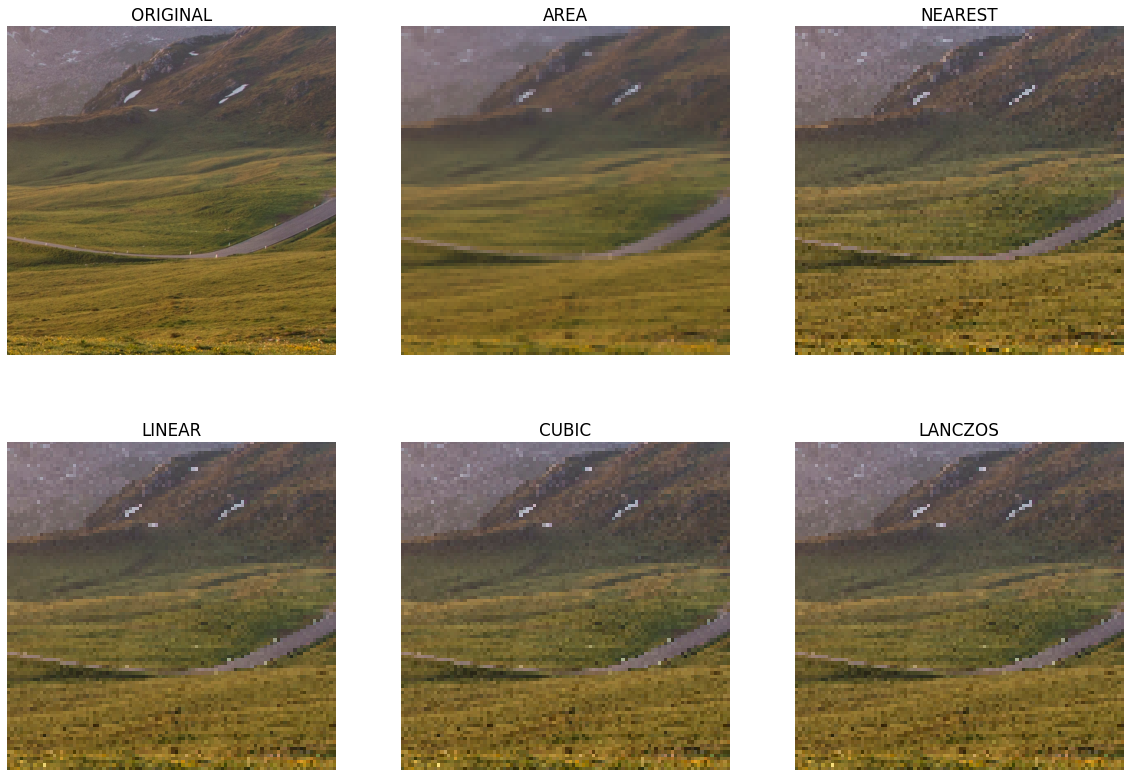

In [5]:
plt.figure(figsize=(20, 14))
ncols = int(np.ceil((len(algos) + 1) / 2))
plt.subplot(2, ncols, 1)
plt.axis("off")
plt.title("ORIGINAL")
# draw original image
plt.imshow(image[1500:2500, 5000:6000])
for num, algo in enumerate(algos):
    # downsample the original image with selected algorithm
    image_resized = cv2.resize(image, (736, 410), interpolation=algos[algo])
    plt.subplot(2, ncols, num + 2)
    plt.axis("off")
    plt.title(algo)
    # draw results
    plt.imshow(image_resized[150:250, 500:600])

For downsampling, the "area" algorithm looks the best (describing what happens under the hood goes beyond the scope of the article). It produces the least noise and artifacts. In fact, it is the preferred choice for downsampling following OpenCV [guidelines](https://docs.opencv.org/4.5.5/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d).

Let's also create a downsampled image with preferred "area" algorithm.

In [6]:
image_downsampled = cv2.resize(image, (736, 410), interpolation=cv2.INTER_AREA)

## Upsampling

Let's now upsample this "area"-downsampled image back to the original size and see which algorithm would work best in this case.

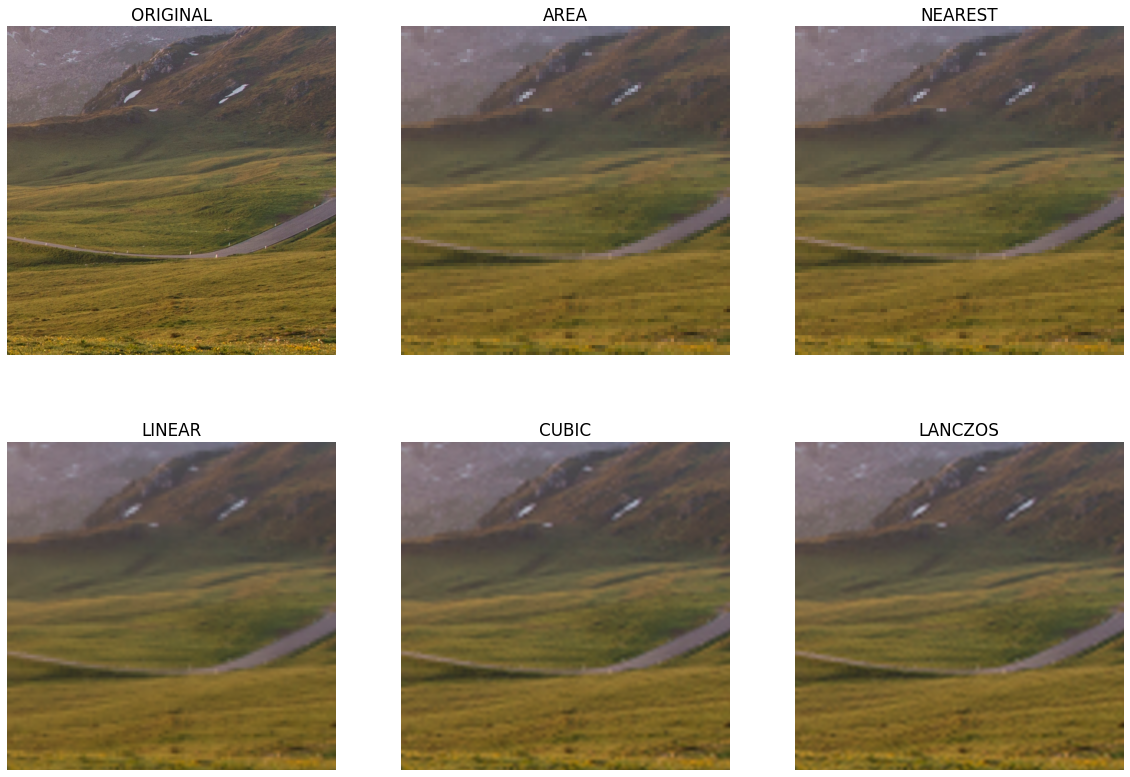

In [7]:
plt.figure(figsize=(20, 14))
ncols = int(np.ceil((len(algos) + 1) / 2))
plt.subplot(2, ncols, 1)
plt.axis("off")
plt.title("ORIGINAL")
# draw original image
plt.imshow(image[1500:2500, 5000:6000])
for num, algo in enumerate(algos):
    # upsample the downsampled image back to the original size
    # with the selected resizing algorithm
    image_resized = cv2.resize(
        image_downsampled, 
        (7360, 4100), 
        interpolation=algos[algo]
    )
    plt.subplot(2, ncols, num + 2)
    plt.axis("off")
    plt.title(algo)
    # draw results
    plt.imshow(image_resized[1500:2500, 5000:6000])

For upsampling, the algorithms produce more consistent results. Nevertheless, "cubic" interpolation looks the least blurred and the closest to the original ("lanczos" provides similar results but is much slower).

So the final verdict here is to use an "area" interpolation for downsampling and a "cubic" algorithm for upsampling.